In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model

In [2]:
dataset_path = "/kaggle/input/oral-cancer/dataset"
batch_size = 16
img_size = (224, 224)

In [3]:
tr_gen = ImageDataGenerator(rescale=1.0 / 255)
val_gen = ImageDataGenerator(rescale=1.0 / 255)
ts_gen = ImageDataGenerator(rescale=1.0 / 255)

In [ ]:
train_gen = tr_gen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
)

val_gen = val_gen.flow_from_directory(
    os.path.join(dataset_path, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
)

test_gen = ts_gen.flow_from_directory(
    os.path.join(dataset_path, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False,
)
print("Class indices:", train_gen.class_indices)


Found 3633 images belonging to 2 classes.
Found 519 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Class indices: {'Normal': 0, 'OSCC': 1}


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load Pretrained EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True 

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=out)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
history=model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[early_stopping])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


228/228 ━━━━━━━━━━━━━━━━━━━━ 215s 587ms/step - accuracy: 0.6461 - auc: 0.7055 - loss: 0.7020 - val_accuracy: 0.5549 - val_auc: 0.5817 - val_loss: 0.7725
Epoch 2/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 44s 192ms/step - accuracy: 0.8209 - auc: 0.9066 - loss: 0.3886 - val_accuracy: 0.4855 - val_auc: 0.4765 - val_loss: 0.9174
Epoch 3/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 43s 185ms/step - accuracy: 0.8975 - auc: 0.9632 - loss: 0.2453 - val_accuracy: 0.5588 - val_auc: 0.5712 - val_loss: 1.1404
Epoch 4/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 43s 187ms/step - accuracy: 0.9242 - auc: 0.9839 - loss: 0.1681 - val_accuracy: 0.7726 - val_auc: 0.8695 - val_loss: 0.5746
Epoch 5/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - accuracy: 0.9480 - auc: 0.9866 - loss: 0.1461 - val_accuracy: 0.8439 - val_auc: 0.9212 - val_loss: 0.4614
Epoch 6/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 42s 184ms/step - accuracy: 0.9559 - auc: 0.9929 - loss: 0.1087 - val_accuracy: 0.8613 - val_auc: 0.9373 - val_loss: 0.3941
Epoch 7/10
228/228 ━━━━━━━━━━━━━

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def evaluate_model(model, train_gen, val_gen, test_gen, history):
    # Evaluate model on training, validation, and test sets
    train_res = model.evaluate(train_gen)
    train_accuracy=train_res[1]
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    
    val_res = model.evaluate(val_gen)
    val_accuracy=val_res[1]
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    
    test_res= model.evaluate(test_gen)
    test_accuracy=test_res[1]
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    
    # Get true labels and predictions
    y_true = test_gen.classes
    y_pred_prob = model.predict(test_gen)
    
    if y_pred_prob.shape[1] > 1: 
        y_pred = np.argmax(y_pred_prob, axis=1)
    else: 
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=test_gen.class_indices.keys(), 
                yticklabels=test_gen.class_indices.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Classification Report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    if history is not None:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history.get('loss', []), label='Train Loss', marker='o')
        plt.plot(history.history.get('val_loss', []), label='Validation Loss', marker='s')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("No training history available. Skipping loss plot.")
    
    # ROC Curve 
    if y_pred_prob.shape[1] == 1:
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("ROC curve is only applicable for binary classification.")

228/228 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9979 - auc: 1.0000 - loss: 0.0100
Training Accuracy: 99.81%
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 737ms/step - accuracy: 0.8860 - auc: 0.9721 - loss: 0.2774
Validation Accuracy: 89.21%


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 49s 751ms/step - accuracy: 0.9504 - auc: 0.5275 - loss: 0.1743
Test Accuracy: 95.96%
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 442ms/step


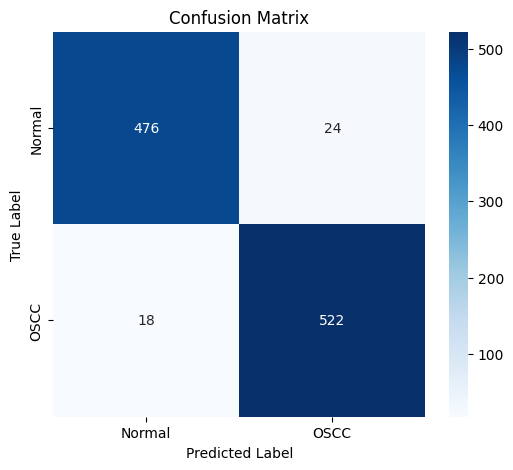

Classification Report:
               precision    recall  f1-score   support

      Normal       0.96      0.95      0.96       500
        OSCC       0.96      0.97      0.96       540

    accuracy                           0.96      1040
   macro avg       0.96      0.96      0.96      1040
weighted avg       0.96      0.96      0.96      1040



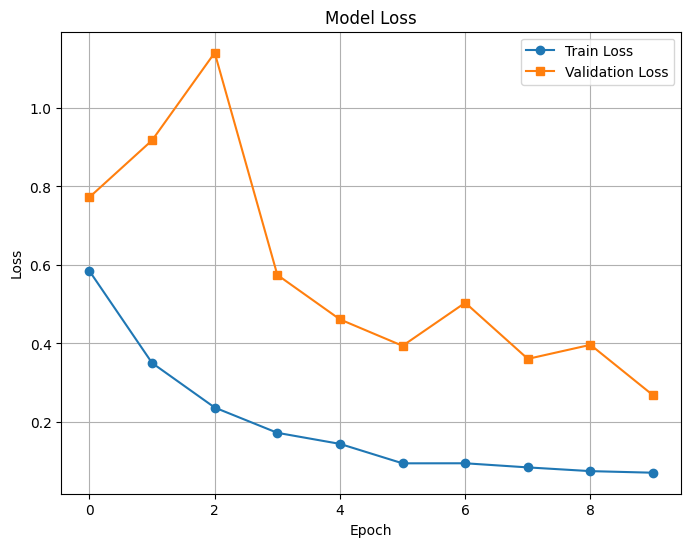

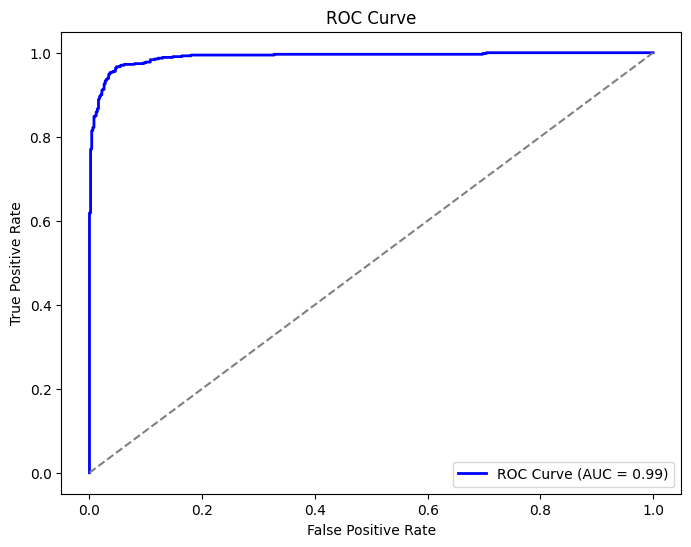

In [8]:
evaluate_model(model, train_gen, val_gen, test_gen, history)

In [9]:
model.save("efficientB0.h5")
print("Model saved as efficientB0.h5")

Model saved as efficientB0.h5
